In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from sklearn import metrics

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from my_utils import dotdict

In [ ]:
from wandb_sweep import get_dls, get_learner

In [ ]:
from model_eval import get_preds, plot_CM, plot_CM_PR, plot_top_losses_glitches

In [ ]:
import wandb

api = wandb.Api()

In [ ]:
sweep_id = "m4nqsh6e"
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")
best_run_config = sweep.best_run().config

wandb: Sorting runs by -summary_metrics.combined_f1_time


In [ ]:
config = dotdict(best_run_config)
config.correct_labels = True
config.inference = True
config.real_gw_eval = True

In [ ]:
config.real_gw_version = 2
# version with shift and vmax=25.5

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

<matplotlib.image.AxesImage>

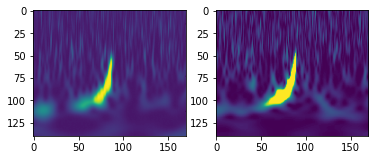

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0][0])
axes[1].imshow(dls.loaders[2].dataset[0][0][0])

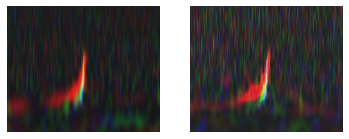

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[0][0].permute(1, 2, 0))
axes[0].set_axis_off()
axes[1].set_axis_off()

<matplotlib.image.AxesImage>

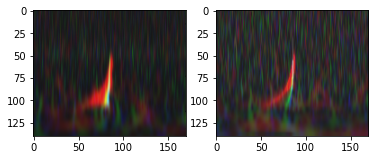

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1742][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[1][0].permute(1, 2, 0))

<matplotlib.image.AxesImage>

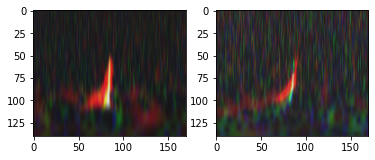

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1743][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[15][0].permute(1, 2, 0))

Now the real gws dset seems more aligned.

In [ ]:
dls.loaders[2].dataset[1][0].max()

tensor(0.8431)

In [ ]:
gws = dls[2].one_batch()
gws[0].shape

torch.Size([22, 3, 140, 170])

In [ ]:
gws[0].mean(dim=[0, 2, 3]), gws[0].std(dim=[0, 2, 3])

(tensor([0.1896, 0.1853, 0.1807]), tensor([0.0942, 0.0866, 0.0734]))

In [ ]:
# gspy stats:  
(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

In [ ]:
dls.train_ds[1743][0].mean(dim=[1, 2]), dls.train_ds[1743][0].std(dim=[1, 2])

(tensor([0.1557, 0.1302, 0.1245]), tensor([0.1219, 0.0668, 0.0489]))

The real GWs have means and stds different thatn the original dset.  
They are even further than the Chirps present in gspy.

In [ ]:
preds, targets, soft_preds, y_true, y_pred = get_preds(learner, ds_idx=2)

In [ ]:
y_true, y_pred

(tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 [tensor(4),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(17),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(12),
  tensor(17),
  tensor(12)])

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(22))
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 4.55%
Macro-averaged F1-score: 2.90%


In [ ]:
metrics.top_k_accuracy_score(y_true, soft_preds, labels=np.arange(22), k=5)

0.13636363636363635

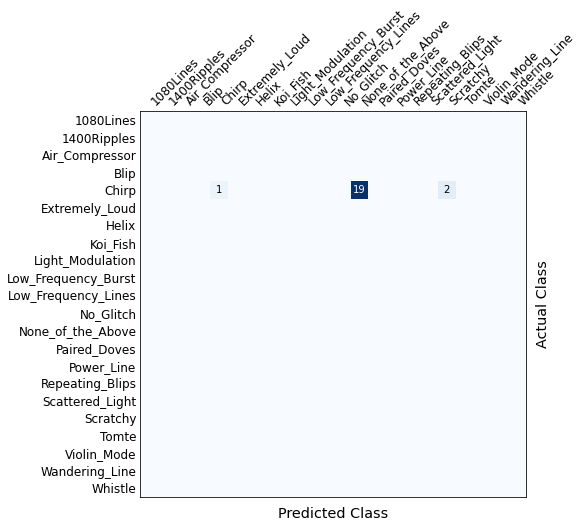

In [ ]:
fig, axes = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab, figsize=(8, 8))

In [ ]:
interp = Interpretation.from_learner(learner, ds_idx=2)
channel_list = [0]*22

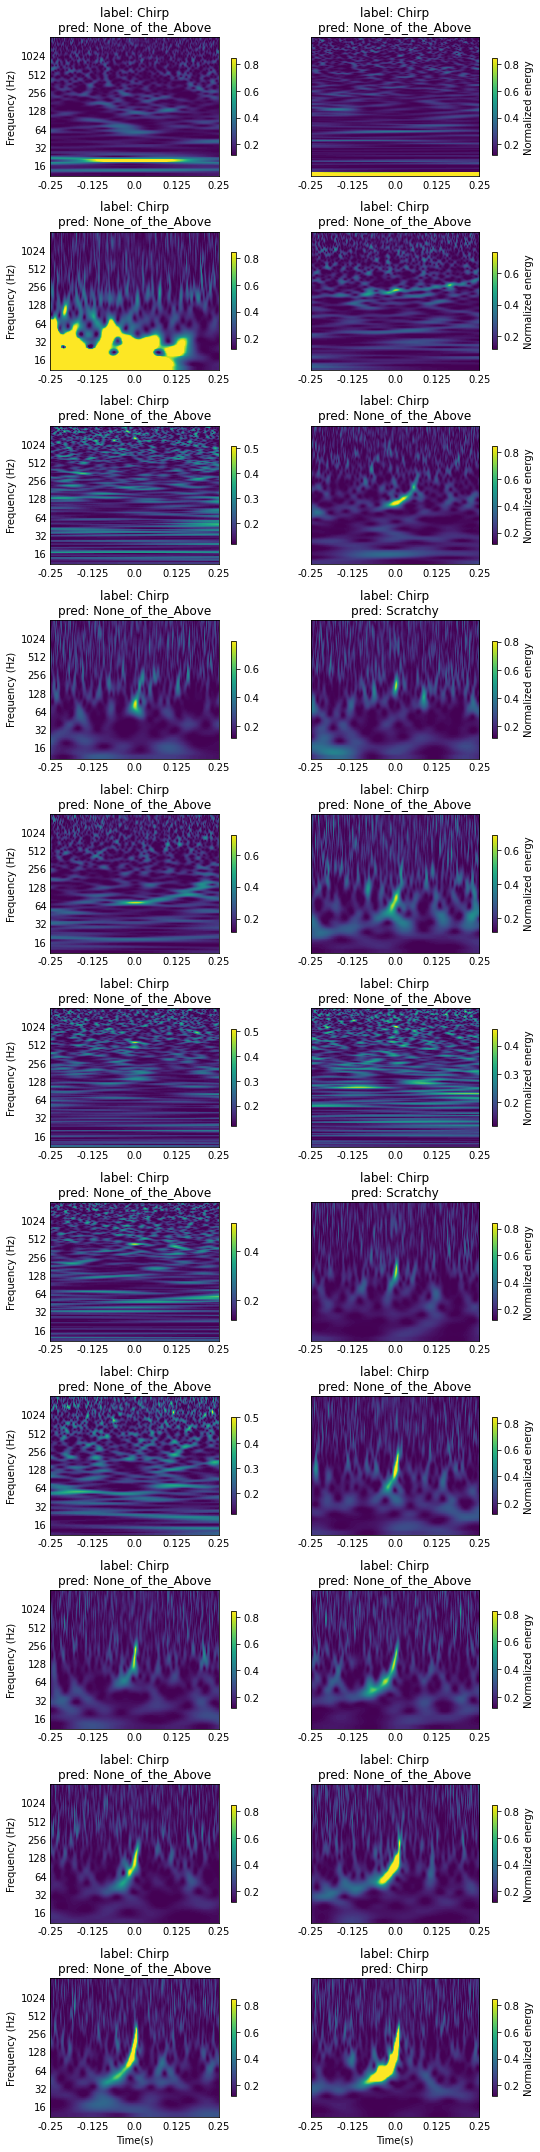

In [ ]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=11, ncols=2,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(8, 30)
)

In [ ]:
top_losses = interp.top_losses(22)

In [ ]:
for idx in top_losses[1][-6:]:
    top5 = preds[idx].topk(5)
    print([f'{vocab[idx]}: {top5[0][i]:.2e}' for i, idx in enumerate(top5[1])])

['None_of_the_Above: 4.43e-01', 'Scratchy: 3.87e-01', 'Whistle: 1.57e-01', 'Wandering_Line: 6.88e-03', '1080Lines: 5.32e-03']
['None_of_the_Above: 9.34e-01', 'Scratchy: 4.88e-02', 'Whistle: 9.73e-03', '1080Lines: 2.59e-03', 'Wandering_Line: 1.60e-03']
['None_of_the_Above: 7.77e-01', 'Scratchy: 1.74e-01', '1080Lines: 2.14e-02', 'Whistle: 1.95e-02', 'Wandering_Line: 3.92e-03']
['None_of_the_Above: 9.36e-01', 'Whistle: 2.58e-02', 'Chirp: 2.32e-02', 'Scratchy: 3.92e-03', 'Power_Line: 3.91e-03']
['None_of_the_Above: 6.93e-01', 'Chirp: 2.55e-01', 'Scratchy: 2.37e-02', '1080Lines: 1.11e-02', 'Whistle: 7.40e-03']
['Chirp: 9.46e-01', 'None_of_the_Above: 3.40e-02', 'Whistle: 1.28e-02', 'Power_Line: 4.45e-03', 'Koi_Fish: 7.93e-04']


##### Changing mean and std to match gspy

In [ ]:
config.real_gw_normalize = True

In [ ]:
dls, _, n_channels = get_dls(config)
learner = get_learner(config, dls, n_channels)
vocab = list(learner.dls.train_ds.class_dict.keys())
learner.load(f"{sweep_id}_run{config.experiment_no}")

<fastai.learner.Learner>

<matplotlib.image.AxesImage>

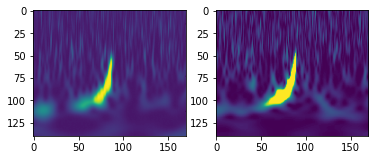

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0][0])
axes[1].imshow(dls.loaders[2].dataset[0][0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<matplotlib.image.AxesImage>

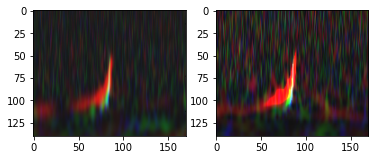

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(dls.train_ds[1741][0].permute(1, 2, 0))
axes[1].imshow(dls.loaders[2].dataset[0][0].permute(1, 2, 0))

In [ ]:
dls.loaders[2].dataset[1][0].max()

tensor(1.1573)

In [ ]:
gws = dls[2].one_batch()
gws[0].mean(dim=[0, 2, 3]), gws[0].std(dim=[0, 2, 3])

(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1411, 0.1077, 0.0831]))

In [ ]:
# gspy stats:  
(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

(tensor([0.1783, 0.1513, 0.1418]), tensor([0.1158, 0.0853, 0.0719]))

In [ ]:
dls.train_ds[1743][0].mean(dim=[1, 2]), dls.train_ds[1743][0].std(dim=[1, 2])

(tensor([0.1557, 0.1302, 0.1245]), tensor([0.1219, 0.0668, 0.0489]))

The real GWs have means and stds matching the original dset.  
They are different that the example chirps, though.

In [ ]:
preds, targets, soft_preds, y_true, y_pred = get_preds(learner, ds_idx=2)

In [ ]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(22))
acc = metrics.accuracy_score(y_true, y_pred) * 100
f1 = metrics.f1_score(y_true, y_pred, average="macro") * 100
print(f"Overall accuracy: {acc:.2f}%")
print(f"Macro-averaged F1-score: {f1:.2f}%")

Overall accuracy: 0.00%
Macro-averaged F1-score: 0.00%


In [ ]:
metrics.top_k_accuracy_score(y_true, soft_preds, labels=np.arange(22), k=5)

0.18181818181818182

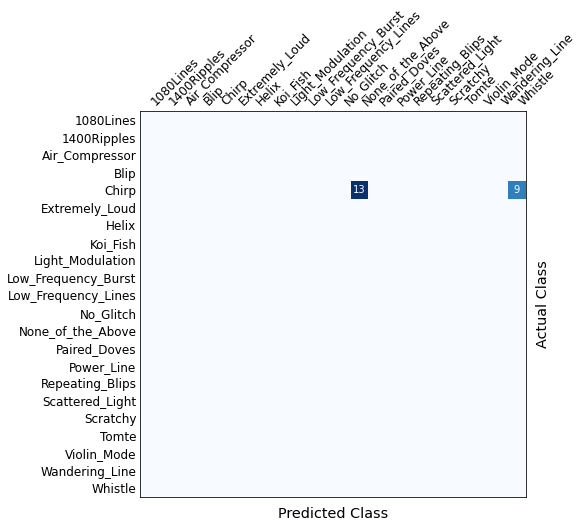

In [ ]:
fig, axes = plot_CM(cm, y_true=y_true, y_pred=y_pred, vocab=vocab, figsize=(8, 8))

The normalization changed many preds to whistles.

In [ ]:
interp = Interpretation.from_learner(learner, ds_idx=2)
channel_list = [0]*22

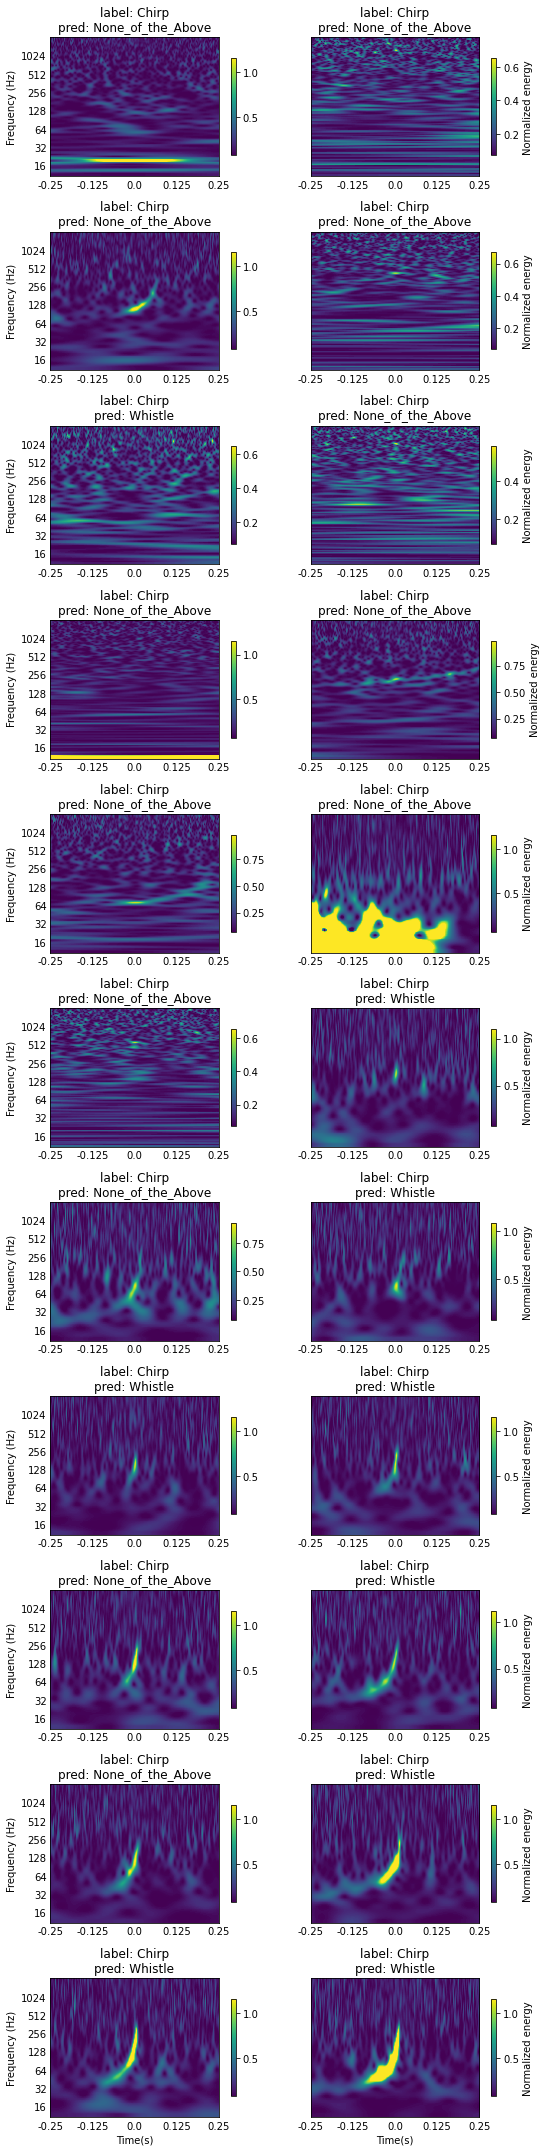

In [ ]:
fig, ax = plot_top_losses_glitches(interp, learner, vocab=vocab, ds_idx=2,
    y_preds=y_pred, channel_list=channel_list,
    largest=True, nrows=11, ncols=2,
    show_label=True, show_pred=True, show_loss=False,
    figsize=(8, 30)
)

In [ ]:
top_losses = interp.top_losses(22)

In [ ]:
for idx in top_losses[1][-6:]:
    top5 = preds[idx].topk(5)
    print([f'{vocab[idx]}: {top5[0][i]:.2e}' for i, idx in enumerate(top5[1])])

['None_of_the_Above: 9.34e-01', 'Whistle: 6.53e-02', 'Wandering_Line: 3.39e-04', 'Violin_Mode: 2.12e-04', 'Koi_Fish: 1.30e-04']
['Whistle: 5.68e-01', 'None_of_the_Above: 4.30e-01', 'Wandering_Line: 6.46e-04', 'Koi_Fish: 4.30e-04', 'Chirp: 3.32e-04']
['None_of_the_Above: 7.36e-01', 'Whistle: 2.58e-01', 'Wandering_Line: 2.28e-03', 'Violin_Mode: 1.07e-03', 'Koi_Fish: 7.94e-04']
['Whistle: 7.16e-01', 'None_of_the_Above: 2.76e-01', 'Chirp: 5.04e-03', 'Koi_Fish: 1.48e-03', 'Wandering_Line: 6.91e-04']
['Whistle: 6.19e-01', 'None_of_the_Above: 2.85e-01', 'Chirp: 8.66e-02', 'Koi_Fish: 5.42e-03', 'Wandering_Line: 1.61e-03']
['Whistle: 3.86e-01', 'None_of_the_Above: 3.07e-01', 'Chirp: 2.93e-01', 'Koi_Fish: 7.66e-03', 'Wandering_Line: 2.77e-03']
